<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pyVIRUS</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>Virus</b> modelling</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pyVIRUS.png"></td>
</tr>
</table>

----
# `pyVIRUS`

pyVIRUS, a program package for for modelling the spread and containment of a virus in a population.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import ipywidgets as widgets

----
# Evolution models (modified SIR)
In this notebook, we look into virus modelling with coupled differential equations.
This setup is actually very similar to our geoscientific decay-series modeling for radiogenic isotopes!

We modify the **SIR** model, which describes how an infection spreads in a population from **healty** individuals via 
**infected** persons to **immune** people, to account for the **loss of immunity**. 

**modSIR** stands for **Susceptible – Infectious – Recovered** - **Loss of Immunity**, it is a box model. 

We define `N` as the total number of individuals. Then we sub-divide:
- $S(t)$: Number of **susceptible** people [1/number]
- $I(t)$: Number of **invected** people [1/number]
- $R(t)$: Number of **recovered** people [1/number]
with $t$ the time.

For the total number of people $N$, we define:
$$
N = S(t)+I(t)+R(t)
$$

If the recovered persons `R` loose their immunity after a certain period, we need to add/subtract
another term to the three equations ($\nu R$):
$$
\begin{array}{rcl}
{{dS} \over {dt}} & = & - \lambda(I) S + \nu R \\
{{dI} \over {dt}} & = & + \lambda(I) S - \gamma I \\
{{dR} \over {dt}} & = & + \gamma I - \nu R \\
\end{array}
$$
with 
- $\lambda$ [1/day] the **infection rate** 
- $\gamma$ [1/day] the **recovery rate**
- $\nu$ [1/day] the **loss-of-immunity rate**

The invection rate itself is a function of $I$:
$$
\lambda = \beta I,
$$
with $\beta$ [1/number/day] the **transmission rate**, often called $R_0$ in the literature.

We start defining the differential equations of the modified SIR model as function `rhs`:

In [2]:
def rhsSIR2(t,y, beta, gamma,nu):
    """
    """
    S, I, R = y
    dSdt = -beta * S * I + nu*R
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I - nu*R
    return [dSdt,dIdt,dRdt]

Next, we need **initial conditions**, the **time** array, and then solve the differential equation with
`odeint` from the `scipy.integrate` package. We pack all three parts into a function `SIRmodel`, and
add plotting commands:

In [3]:
def runSIR2(beta,gamma,nu,tmax=50,N=50):
    """
    """
    # Total population, N.
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    #beta, gamma = 2.2, 1./28
    # A grid of time points (in days)
    t = np.linspace(0, tmax, 5*tmax)
    # The SIR model differential equations.
    # Initial conditions vector
    y0 = [S0, I0, R0]
    # Integrate the SIR equations over the time grid, t.
    solution = integrate.solve_ivp(rhsSIR2,[t[0],t[-1]],y0,t_eval=t, args=(beta, gamma, nu))
    S, I, R = solution.y
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    plt.figure(figsize=(10.0,6.0))
    plt.xlabel('Time [days]')
    plt.ylabel('People [#]')
    plt.ylim([0,1.1*N])
    plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
    plt.grid(which='major', c='lightgrey', lw=1, ls=':')
    plt.legend()


We test is model manually. We therefore need estimates for $S_0$ and $I_0$, as well as the
rates $\beta$ and $\gamma$.

We use as example a small school, with $N=50$ pupils. One is infected initially ($I_0=1$).

The invection rate $\beta$ we derive from the spread of the infection during a day:
- On one day, 40 pupils are susceptible, 8 are infected.
- On the next day, 30 pupils are susceptible, and 18 infected.
- On the next day, 3 previously infected have recovered.

Then $\beta$ is derived as ratio *decrease in susceptible* to the product of *susceptible* and *infected*,
the latter the potential pairs, the former the real pairs:
$$
\beta = \frac{10}{40*8}
$$
And $\gamma$ describes the ration of *recovered* to *infected* pupils:
$$
\gamma = \frac{3}{15}
$$

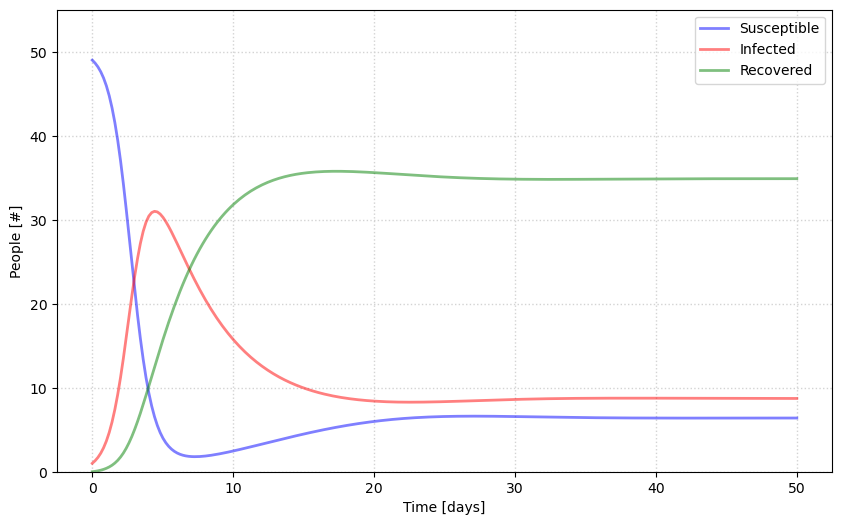

In [4]:
beta  = 10 / (40*8)
gamma = 3/15
nu    = 1/20
runSIR2(beta,gamma,nu,N=50)

Finally, we wrap this as interactive model into the `widgets` function of the `pywidgets`package. 

In [5]:
# call interactive module
w = dict(
beta=widgets.FloatSlider(min=0.001,max=0.05,step=0.01,value=0.03,description='beta'),
gamma=widgets.FloatSlider(min=0.1,max=0.5,step=0.01,value=0.2,description='gamma'),
nu=widgets.FloatSlider(min=0.0,max=1,step=0.01,value=1/20,description='nu'),
tmax=widgets.IntSlider(min=10,max=100,step=10,value=60,description='Days'))

output = widgets.interactive_output(runSIR2, w)
box = widgets.HBox([widgets.VBox([*w.values()]), output])
display(box)

----